In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
%matplotlib inline

In [2]:
def propose_regions(image, threshold=0.1):
    ''' Create binary region predictions from an image.
    
    Parameters
    ----------
    image : numpy.ndarray, shape=(R, C, 3)
        The image for which to propose regions.
        
    threshold : Real ∈ [0, 1], optional (default=0.1)
        The color threshold at which to propose regions.
        
    Returns
    -------
    numpy.ndarray, shape=(R, C)
        The binary image holding regions of interest.
    '''
    roi_img = np.zeros(image.shape[:2], dtype=np.uint8) # shape (R, C)
    
    # regions of interest (RoIs) are where the maximum RGB difference across a single
    # pixel location is at least 0.1
    
    # get the color vector differences by taking (R, C, 3, 1) - (R, C, 1, 3)
    diffs = np.abs(image[..., np.newaxis] - image[:, :, np.newaxis, :])
    
    # find where the color difference is > 0.1
    rois = np.where(np.max(diffs, axis=(2, 3)) > 0.1)
    
    # those areas are foreground (objects)
    roi_img[rois] = 1
    return roi_img

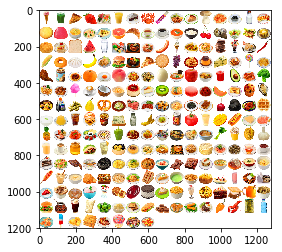

In [3]:
rgba_image = mpimg.imread('food.png')

rgba_pil = PIL.Image.open('food.png')
img = np.array(rgba_pil.convert('RGB'))

row_step = 1200//15
col_step= 1280//16
shelf_coord = [260, 380, 500, 620, 770] #coordinates of the first, second ... shelves


plt.imshow(img)

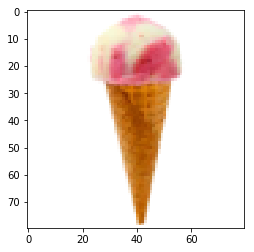

In [4]:
plt.imshow(img[:row_step, :col_step])

(80, 80, 3)


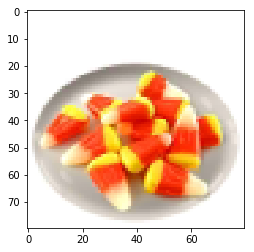

In [5]:
#16 images across, 15 down
images = []
labels = []
for i in range(0, 1200, row_step):
    for j in range(0, 1280, col_step):
        images.append(img[i: i + row_step, j : j + col_step, :])
images = images[:-8]
test_shape = images[-1]
plt.imshow(test_shape)
print(test_shape.shape)

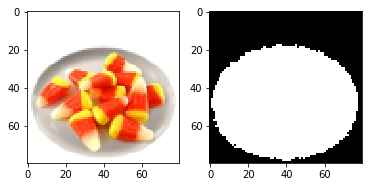

In [6]:
roi_image = propose_regions(test_shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_shape)
ax[1].imshow(roi_image, 'gray')

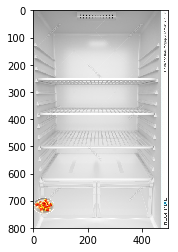

In [15]:
fridge = mpimg.imread('fridge.jpg')
fridge = np.array(fridge)



fridge = layer_image(fridge, roi_image, test_shape, shift= (670,0 ))
plt.imshow(fridge)

In [16]:
roi_images = [propose_regions(i) for i in images]
#for i in images:
#    roi_images.append(propose_regions(i))


In [17]:
roi_images = [propose_regions(np.array(images))]

ValueError: operands could not be broadcast together with shapes (232,80,80,3,1) (232,80,1,80,3) 

In [18]:
def fun(num):
    return num**2
a = [1,2,3]
b = [fun(np.array(a))]
print(b)

[array([1, 4, 9], dtype=int32)]


In [19]:
def layer_image(background, roi_image, image, shift = (0,0)):
    ''' Replaces the pixels of the foreground with the pixels of the colored image
    wherever the image region is true.
    
    Parameters
    ----------
    background : numpy.array of shape (M,N,3)
    
    roi_image : numpy.array of shape (X,Y,3) where X and Y are <= M and N.
                Elements are 1 where the object region is detected and 0 where it is not.
    
    image : numpy.array of shape (X,Y,3).
            Elements are the color of the image
    
    shift : Tuple(int, int)
                The amount of shift (down, right) from (0,0), or top left, of the background
        
    Returns
    -------
    Numpy.array of shape (M,N,3)
        Altered background array
    '''
    shift_down, shift_right = shift
    for i in range(roi_image.shape[0]):
        for j in range(roi_image.shape[1]):
            if roi_image[i][j] == 1:
                background[i + shift_down][j + shift_right] = image[i][j]
    return background

In [20]:
def parse_food():


    rgba_pil = PIL.Image.open('food.png')
    img = np.array(rgba_pil.convert('RGB'))

    row_step = 1200 // 15
    col_step = 1280 // 16

    images = [] #list of each image's rgb arrays
    labels = [] #list of each image's label

    for i in range(0, 1200, row_step):
        for j in range(0, 1280, col_step):
            images.append(img[i: i + row_step, j: j + col_step, :])
            #CHANGE THIS, Check this:
            labels.append("X")

    images = np.array(images[:-8]) #takes out the random lack of food at last row
    # list of each regionized image where 1 indicates object and 0 indicates background
    roi_images = np.array([propose_regions(i) for i in images])

    return images, roi_images, labels

In [113]:
image_width = 80
image_height = 80
def generate_fridge(num_items):
    """
    num_items >=0 && <=25
    """

    images, roi_images, labels = parse_food()
    right = [shift for shift in range(30, 400, 80)]
    shelf_coord = [180, 300, 420, 540, 690]  # coordinates of the first, second ... shelves
    shift_ls = []
    for shelf in shelf_coord:
        for pos in right:
            shift_ls.append([(shelf, pos)])
    
    fridge = mpimg.imread('fridge.jpg')
    fridge = np.array(fridge)
    
    boxes_list = []
    labels_list = []
    
    for i in range(num_items):
        #rand_shelf = shelf_coord[np.random.randint(0, len(shelf_coord))]
        randint = np.random.randint(0, len(images))
        #rand_image = images[np.random.randint(0, len(images))]
        shift = shift_ls.pop(np.random.randint(0, len(shift_ls))) #random right shift
        fridge = layer_image(fridge, roi_images[randint], images[randint], shift[0])
        boxes_list.append(np.array([shift[0][1], shift[0][0], shift[0][1]+image_width, shift[0][0]+image_height], dtype=np.float32))
        labels_list.append(np.array(labels[randint]))
    boxes_list = np.vstack(boxes_list)   
    plt.imshow(fridge)
    return fridge,boxes_list,np.array(labels_list)


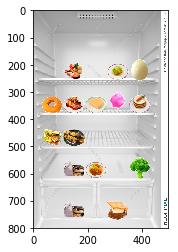

In [114]:
fridge, boxes, labels = generate_fridge(15)


In [115]:
print(fridge.shape)

(800, 497, 3)


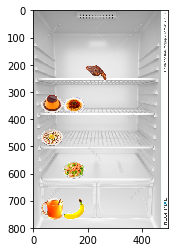

In [116]:
set1 = [generate_fridge(np.random.randint(1,25)) for i in range(10)]
set2 = [generate_fridge(np.random.randint(1,25)) for i in range(3)]


In [60]:
set1

[(array([[[155, 155, 155],
          [153, 153, 153],
          [149, 149, 149],
          ...,
          [254, 254, 254],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[154, 154, 154],
          [158, 158, 158],
          [154, 154, 154],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[151, 151, 151],
          [153, 153, 153],
          [157, 157, 157],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[201, 201, 201],
          [203, 203, 203],
          [205, 205, 205],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[201, 201, 201],
          [203, 203, 203],
          [206, 206, 206],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[201, 201, 201],
          [203, 203, 203],
          [206, 206, 206

In [117]:
train_images = np.array([i[0] for i in set1])
train_boxes = np.array([i[1] for i in set1])
train_labels = np.array([ i[2] for i in set1])

val_images = np.array([ i[0] for i in set2])
val_boxes = np.array([ i[1] for i in set2])
val_labels = np.array([ i[2] for i in set2])


In [118]:
print(train_images.shape, train_boxes.shape, train_labels.shape,val_images.shape,val_boxes.shape, val_labels.shape)

(10, 800, 497, 3) (10,) (10,) (3, 800, 497, 3) (3,) (3,)


In [119]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F

from detection_utils.boxes import non_max_suppression, generate_targets
from detection_utils.metrics import compute_recall, compute_precision
from detection_utils.pytorch import softmax_focal_loss

In [120]:
batch_size = 16  # feel free to manipulate this as needed for GPU memory or as desired

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [121]:
#print(train_images)
train_images = torch.tensor(train_images.transpose(0, 3, 1, 2)).to(device)
val_images = torch.tensor(val_images.transpose(0, 3, 1, 2)).to(device)
print(train_boxes.shape)
print(val_images.shape)
print(train_labels.shape)

(10,)
torch.Size([3, 3, 800, 497])
(10,)


In [122]:
num_categories = 15
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.conv3 = nn.Conv2d(20, 30, 3, padding=1)
        self.conv4 = nn.Conv2d(30, 40, num_categories, padding=1)
        
        self.classification = nn.Conv2d(40, 4, 1) # background / rectangle / triangle / circle
        self.regression = nn.Conv2d(40, 4, 1)
        
        for layer in (self.conv1, self.conv2, self.conv3, self.conv4,
                     self.classification, self.regression):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)

        nn.init.constant_(self.classification.bias[0], -4.6)  # rougly -log((1-π)/π) for π = 0.01
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        
        classifications = self.classification(x).permute(0, 2, 3, 1)                          # (N, R, C, # classes)
        classifications = classifications.reshape(x.shape[0], -1, classifications.shape[-1])  # (N, R*C, # classes)
        regressions = self.regression(x).permute(0, 2, 3, 1)                                  # (N, R, C, # classes)
        regressions = regressions.reshape(x.shape[0], -1, 4)                                  # (N, R*C, 4)
        return classifications, regressions

In [123]:
#Check this: anchor size needs to be tested
anchor_boxes = []
for y in range(0, train_images.shape[2], 40):
    for x in range(0, train_images.shape[3], 40):
        anchor_boxes.append(np.array([-40, -40, 40, 40]) + np.array([x, y, x, y]))
anchor_boxes = np.vstack(anchor_boxes)
# anchor_boxes are in xyxy format

In [124]:
{x.shape for x in train_boxes}

{(2, 4), (7, 4), (14, 4), (15, 4), (16, 4), (21, 4), (22, 4), (23, 4)}

In [125]:
train_labels

array([array(['X', 'X', 'X', 'X', 'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'], dtype='<U1'),
       array(['X', 'X', 'X'

In [126]:
{x.shape for x in train_labels}

{(2,), (7,), (14,), (15,), (16,), (21,), (22,), (23,)}

In [127]:
print(type(train_boxes))
print(type(train_labels))

print((train_boxes.shape))
print((train_labels.shape))

print(type(anchor_boxes))
print(anchor_boxes.shape)

train_cls_targs, train_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1)
                                         for bxs, lbls in zip(train_boxes, train_labels)))
val_cls_targs, val_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1) 
                                     for bxs, lbls in zip(val_boxes, val_labels)))

# For convenience (and to minimize data transfers) we'll shove all of this onto our
# device as well. This only takes a couple of megabytes of GPU memory
train_reg_targs = torch.tensor(train_reg_targs).float().to(device)
train_cls_targs = torch.tensor(train_cls_targs).long().to(device)
val_reg_targs = torch.tensor(val_reg_targs).float().to(device)
val_cls_targs = torch.tensor(val_cls_targs).long().to(device)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(10,)
(10,)
<class 'numpy.ndarray'>
(260, 4)


ValueError: invalid literal for int() with base 10: '-'

In [51]:
print(type(train_boxes))
print(type(train_labels))


print((train_boxes.shape))
print((train_labels.shape))

train_cls_targs, train_reg_targs = zip(*(generate_targets(anchor_boxes, np.array(bxs), lbls, 0.2, 0.1)
                                         for bxs, lbls in 
                                         zip(train_boxes, train_labels)))
"""val_cls_targs, val_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1) 
                                     for bxs, lbls in zip(val_boxes, val_labels)))

# For convenience (and to minimize data transfers) we'll shove all of this onto our
# device as well. This only takes a couple of megabytes of GPU memory
train_reg_targs = torch.tensor(train_reg_targs).float().to(device)
train_cls_targs = torch.tensor(train_cls_targs).long().to(device)
val_reg_targs = torch.tensor(val_reg_targs).float().to(device)
val_cls_targs = torch.tensor(val_cls_targs).long().to(device)"""

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(100,)
(100,)


TypeError: only integer scalar arrays can be converted to a scalar index